{'general': {'test_mode': 'One_out', 'window_size': 900, 'overlap': 0.98, 'feat_dim': None, 'pretrain_model': None, 'finetune_model': None, 'batch_size': 128, 'freeze': False}, 'kdd_pretrain': {'epoch': 500, 'lr': 0.0001, 'optimizer': 'RAdam', 'weight_decay': None, 'harden': False}, 'kdd_finetune': {'epoch': 2000, 'lr': 1e-05, 'optimizer': 'RAdam', 'weight_decay': None}, 'limu_pretrain': {'epoch': 10, 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': None, 'harden': False}, 'limu_finetune': {'epoch': 10, 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': None, 'classifier': 'gru'}, 'limu_mask': {'mask_ratio': 0.15, 'mask_alpha': 6, 'max_gram': 10, 'mask_prob': 0.8, 'replace_prob': 0.0}, 'kdd_model': {'d_hidden': 64, 'd_ff': 256, 'n_heads': 8, 'n_layers': 1, 'dropout': 0.1, 'pos_encoding': 'learnable', 'activation': 'gelu', 'norm': 'BatchNorm', 'projection': 'linear'}, 'limu_model': {'d_hidden': 24, 'd_ff': 72, 'n_heads': 4, 'n_layers': 4, 'emb_norm': False}, 'limu_classifier': {'gru_v1'

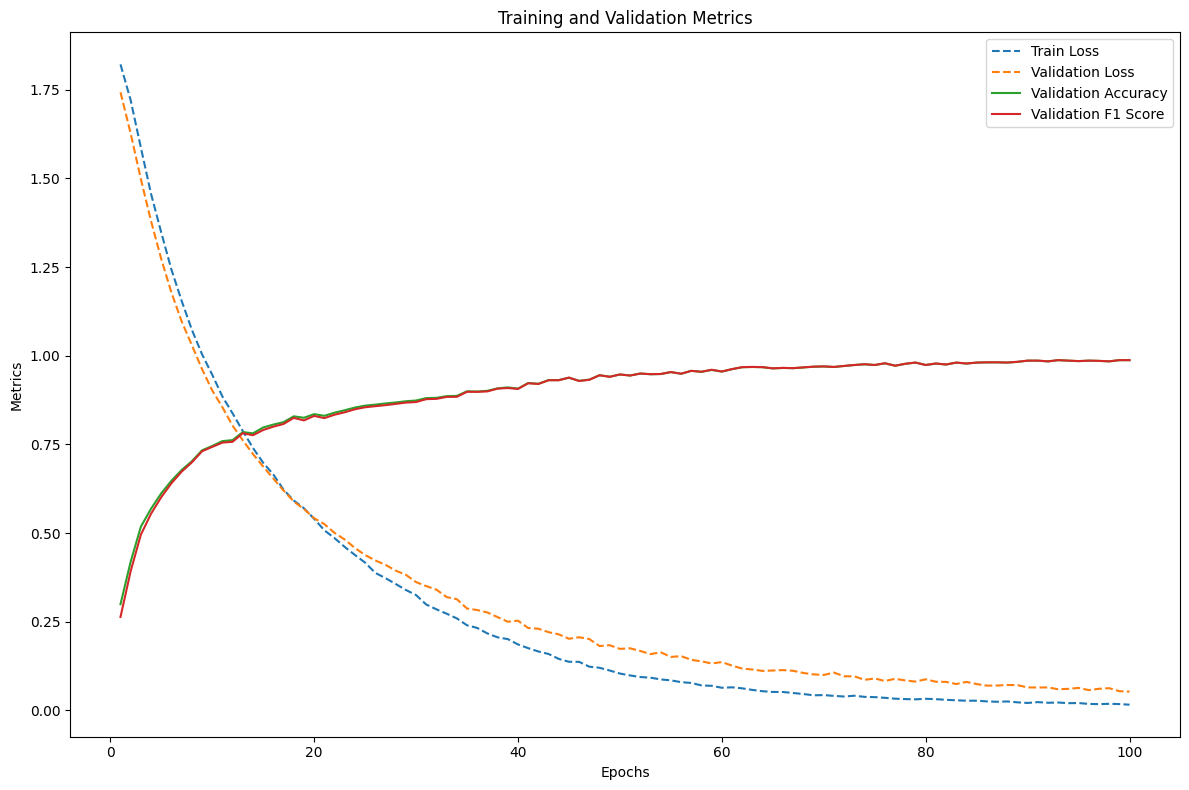

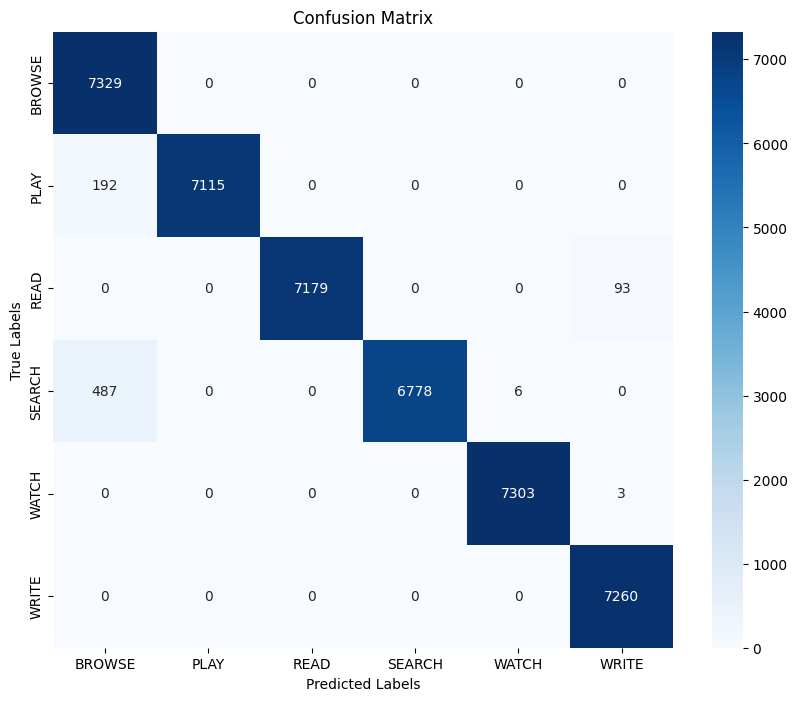

In [1]:
import json
import sys

from modules.finetune_hyperparameters import KDD_Finetune_Hyperparameters
from modules.kdd_model import kdd_model4pretrain, kdd_model4finetune
from modules.pretrain_hyperparameters import KDD_Pretrain_Hyperparameters
from utils.finetune import finetune_kdd_model, eval_finetune_kdd_model
from utils.load_data_from_file import load_mixed_data, prepare_mixed_data_loader, load_one_out_data, \
    prepare_one_out_data_loader
from utils.pretrain import pretrain_kdd_model


def main():
    # Load the config from JSON file first
    with open("utils/config.json", "r") as file:
        config = json.load(file)
    print(config)

    config["general"]["pretrain_model"] = "results/kdd_model/One_out/linear/pretrain/window_size_30sec/feat_dim_2/freeze_False_epoch_1000_lr_0.0001_d_hidden_64_d_ff_256_n_heads_8_n_layer_1_pos_encode_learnable_activation_gelu_norm_BatchNorm"

    config["general"]["overlap"] = 0.998
    
    config["kdd_finetune"]["epoch"] = 100
    
    # First load the data into dataloader according to chosen test_mode: Mixed or One_out
    if config["general"]["test_mode"] == "Mixed":
        data, labels, encoder = load_mixed_data(window_size=config["general"]["window_size"],
                                                overlap=config["general"]["overlap"])

        num_classes = len(encoder.classes_)
        feat_dim = data[0].shape[1]
        config["general"]["feat_dim"] = feat_dim
        labels_dim = labels.shape
        print(f"The number of classes is {num_classes}, the feat_dim is {feat_dim}, the labels_dim is {labels_dim}")

        eyegaze_data_loader = (prepare_mixed_data_loader
                               (data, labels, batch_size=config["general"]["batch_size"],
                                max_len=config["general"]["window_size"]))

    elif config["general"]["test_mode"] == "One_out":
        train_data, train_labels, test_data, test_labels, encoder = (load_one_out_data
                                                                     (window_size=config["general"]["window_size"],
                                                                      overlap=config["general"]["overlap"]))

        num_classes = len(encoder.classes_)
        feat_dim = train_data[0].shape[1]
        config["general"]["feat_dim"] = feat_dim
        print(f"The number of classes is {num_classes}, the feat_dim is {feat_dim}")

        eyegaze_data_loader = (prepare_one_out_data_loader
                               (train_data, train_labels, test_data, test_labels,
                                batch_size=config["general"]["batch_size"],
                                max_len=config["general"]["window_size"]))
    else:
        print("Either Mixed / One_out")
        sys.exit()

    # ==================================================================================================================
    # If the pretrain_model path is not provided, start with pretraining the model
    if config["general"]["pretrain_model"] is None:
        hyperparameters = KDD_Pretrain_Hyperparameters(config)
        model = kdd_model4pretrain(config, feat_dim)
        loss = hyperparameters.loss
        optimizer = hyperparameters.optimizer(model.parameters(), hyperparameters.lr,
                                              weight_decay=hyperparameters.weight_decay)

        pretrain_kdd_model(model, loss, optimizer, eyegaze_data_loader[0], config)

    # If the pretrain_model path is provided, meaning that there is already a pretrained model, then directly finetune
    # After pretrain, finetune will be performed automatically, because the pretrain_model will be filled
    hyperparameters = KDD_Finetune_Hyperparameters(config)
    model = kdd_model4finetune(config, feat_dim, num_classes)
    loss = hyperparameters.loss
    optimizer = hyperparameters.optimizer(model.parameters(), hyperparameters.lr,
                                          weight_decay=hyperparameters.weight_decay)

    # eyegaze_data_loader[1] is the training set, and eyegaze_data_loader[2] is the validation set
    finetune_kdd_model(model, loss, optimizer, eyegaze_data_loader[1], eyegaze_data_loader[2], config)

    eval_finetune_kdd_model(model, eyegaze_data_loader[3], config, encoder)


if __name__ == "__main__":
    main()
